<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: NPL on Intermittent Fasting and Keto Diet

---

# Part 3

In [1]:
# Import libaries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score

import warnings
warnings.simplefilter("ignore")

In [2]:
# We are dealing with large data sets, so setting max number of column and row displays to be unlimited
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Reading in the cleaned data
df = pd.read_csv('data/subreddit_stem_cleaned.csv')

In [4]:
df.head()

,title,selftext,subreddit,created_utc,post_word_count,post_length,cleantext_stem
0,Plateau sruggles,I (27F) have been intermittent fasting for abo...,0,1625589667,123,660,27f intermitt fast 2 month start weight 145lb ...
1,Can I still do IF/OMAD now that I started exer...,"I started lifting 4x/week (about 40 minutes), ...",0,1625586042,127,679,start lift 4xweek 40 minut well take lot marti...
2,A new mindset,"Hello everyone,\n\n I am a mostly lurker here...",0,1625584307,182,929,hello everyon mostli lurker reddit first id li...
3,Weekend habits are making it difficult to loos...,"Hi everyone,\n\nI have been doing IF (16:8) fo...",0,1625582039,110,569,hi everyon 168 almost 3 year remain consist te...
4,Are these times acceptable for IF?,"So, due to loss of employment, family has take...",0,1625582007,167,806,due loss employ famili taken bother tri use li...


## Baseline Model

In [5]:
df['subreddit'].value_counts(normalize = True)

1    0.544412
0    0.455588
Name: subreddit, dtype: float64

Given that we have quite balanced data between both classes, our baseline model accuracy is the probability from our majority subreddit -- Keto diet. Our baseline accuracy is 54.4%. Hopefully we can models that score better than this score during our modeling.

## Modeling

In [6]:
X = df['cleantext_stem']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [7]:
print(y_train.shape)
print(y_test.shape)

(7717,)
(2573,)


In [8]:
# Vectorizer parameters:
tvec_params = {
    'tvec__max_features': [None, 5_000],
    'tvec__max_df': [0.5, 0.9],
    'tvec__ngram_range':[(1,1), (1,2)]
}

cvec_params = {
    'cvec__max_features': [None, 5_000],
    'cvec__max_df': [0.5, 0.9],
    'cvec__ngram_range':[(1,1), (1,2)],
}

In [9]:
def model(vec_inst, vectorizer, mod_inst, model, vec_params):
    pipe = Pipeline([
        (vec_inst, vectorizer),
        (mod_inst, model)])
    
    gs = GridSearchCV(pipe, param_grid = {**vec_params})
    gs.fit(X_train, y_train)
    
    print('*'*80)
    print(f'MODEL = {model}, VECTORIZER = {vectorizer}')
    print('*'*80)
    print(f'Best fitting parameters: {gs.best_params_}\n')
    print(f'Best score: {round(gs.best_score_, 3)}')
    print(f'Test score: {round(gs.score(X_test, y_test), 3)}\n')
    
    # Get predictions
    preds = gs.predict(X_test)
    
    print('Classification report:')
    print(classification_report(y_test, preds))
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    plot_confusion_matrix(gs, X_test, y_test, values_format='d');
    
    # Save best model results to Dataframe
    df = pd.DataFrame()
    df['model_vec'] = [f'{mod_inst}_{vec_inst}']
    df['best_params'] = [gs.best_params_]
    df['train_score'] = gs.best_score_
    df['test_score'] = gs.score(X_test, y_test)
    df['sensitivity'] =  tp / (tp + fn)
    df['specificity'] = tn / (tn + fp)
    df['precision'] = tp / (tp + fp)
    df['f1_score'] = f1_score(y_test, preds)
    df['tn'] = tn
    df['fp'] = fp
    df['fn'] = fn
    df['tp'] = tp
    
    return df

In [10]:
df_all = []

********************************************************************************
MODEL = LogisticRegression(), VECTORIZER = TfidfVectorizer()
********************************************************************************
Best fitting parameters: {'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2)}

Best score: 0.909
Test score: 0.902

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1172
           1       0.91      0.91      0.91      1401

    accuracy                           0.90      2573
   macro avg       0.90      0.90      0.90      2573
weighted avg       0.90      0.90      0.90      2573



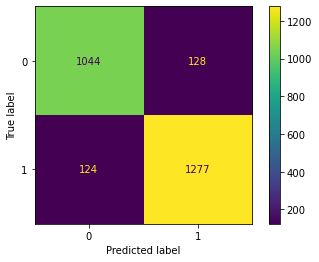

In [11]:
lr_tvec = model('tvec', TfidfVectorizer(), 'lr', LogisticRegression(), tvec_params)
lr_tvec.head().T

df_all.append(lr_tvec)

********************************************************************************
MODEL = LogisticRegression(), VECTORIZER = CountVectorizer()
********************************************************************************
Best fitting parameters: {'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 2)}

Best score: 0.904
Test score: 0.898

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1172
           1       0.92      0.89      0.90      1401

    accuracy                           0.90      2573
   macro avg       0.90      0.90      0.90      2573
weighted avg       0.90      0.90      0.90      2573



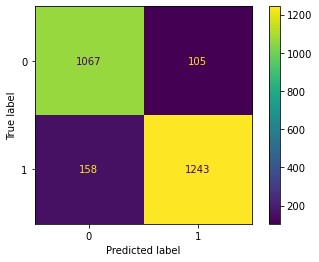

In [12]:
lr_cvec = model('cvec', CountVectorizer(), 'lr', LogisticRegression(), cvec_params)
lr_cvec.head().T

df_all.append(lr_cvec)

********************************************************************************
MODEL = KNeighborsClassifier(), VECTORIZER = TfidfVectorizer()
********************************************************************************
Best fitting parameters: {'tvec__max_df': 0.5, 'tvec__max_features': None, 'tvec__ngram_range': (1, 1)}

Best score: 0.805
Test score: 0.781

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1172
           1       0.80      0.80      0.80      1401

    accuracy                           0.78      2573
   macro avg       0.78      0.78      0.78      2573
weighted avg       0.78      0.78      0.78      2573



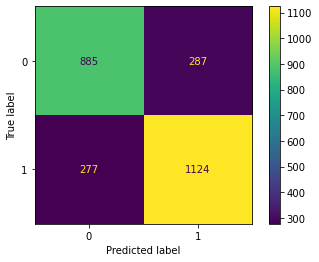

In [13]:
knn_tvec = model('tvec', TfidfVectorizer(), 'knn', KNeighborsClassifier(), tvec_params)
knn_tvec.head().T

df_all.append(knn_tvec)

********************************************************************************
MODEL = KNeighborsClassifier(), VECTORIZER = CountVectorizer()
********************************************************************************
Best fitting parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1)}

Best score: 0.621
Test score: 0.614

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.98      0.70      1172
           1       0.95      0.31      0.46      1401

    accuracy                           0.61      2573
   macro avg       0.75      0.64      0.58      2573
weighted avg       0.77      0.61      0.57      2573



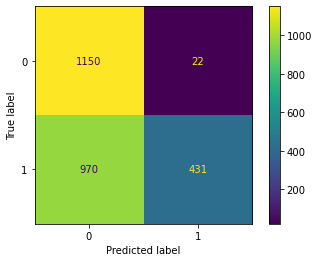

In [14]:
knn_cvec = model('cvec', CountVectorizer(), 'knn', KNeighborsClassifier(), cvec_params)
knn_cvec.head().T

df_all.append(knn_cvec)

********************************************************************************
MODEL = MultinomialNB(), VECTORIZER = TfidfVectorizer()
********************************************************************************
Best fitting parameters: {'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2)}

Best score: 0.878
Test score: 0.876

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1172
           1       0.87      0.91      0.89      1401

    accuracy                           0.88      2573
   macro avg       0.88      0.87      0.87      2573
weighted avg       0.88      0.88      0.88      2573



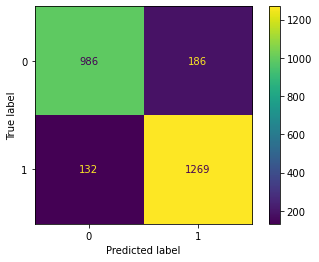

In [15]:
nb_tvec = model('tvec', TfidfVectorizer(), 'nb', MultinomialNB(), tvec_params)
nb_tvec.head().T

df_all.append(nb_tvec)

********************************************************************************
MODEL = MultinomialNB(), VECTORIZER = CountVectorizer()
********************************************************************************
Best fitting parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2)}

Best score: 0.893
Test score: 0.887

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1172
           1       0.90      0.89      0.90      1401

    accuracy                           0.89      2573
   macro avg       0.89      0.89      0.89      2573
weighted avg       0.89      0.89      0.89      2573



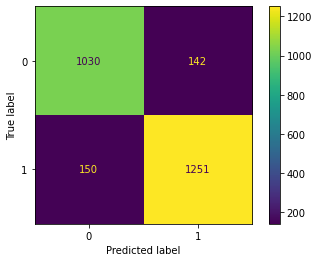

In [16]:
nb_cvec = model('cvec', CountVectorizer(), 'nb', MultinomialNB(), cvec_params)
nb_cvec.head().T

df_all.append(nb_cvec)

********************************************************************************
MODEL = RandomForestClassifier(), VECTORIZER = TfidfVectorizer()
********************************************************************************
Best fitting parameters: {'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2)}

Best score: 0.915
Test score: 0.914

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1172
           1       0.93      0.91      0.92      1401

    accuracy                           0.91      2573
   macro avg       0.91      0.91      0.91      2573
weighted avg       0.91      0.91      0.91      2573



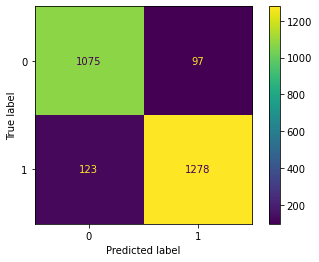

In [17]:
rf_tvec = model('tvec', TfidfVectorizer(), 'rf', RandomForestClassifier(), tvec_params)
rf_tvec.head().T

df_all.append(rf_tvec)

********************************************************************************
MODEL = RandomForestClassifier(), VECTORIZER = CountVectorizer()
********************************************************************************
Best fitting parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2)}

Best score: 0.914
Test score: 0.912

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1172
           1       0.93      0.91      0.92      1401

    accuracy                           0.91      2573
   macro avg       0.91      0.91      0.91      2573
weighted avg       0.91      0.91      0.91      2573



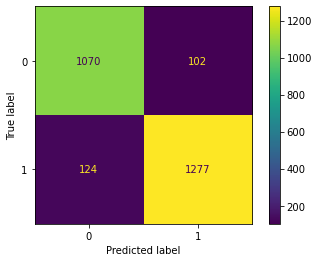

In [18]:
rf_cvec = model('cvec', CountVectorizer(), 'rf', RandomForestClassifier(), cvec_params)
rf_cvec.head().T

df_all.append(rf_cvec)

********************************************************************************
MODEL = AdaBoostClassifier(), VECTORIZER = TfidfVectorizer()
********************************************************************************
Best fitting parameters: {'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2)}

Best score: 0.898
Test score: 0.892

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1172
           1       0.89      0.91      0.90      1401

    accuracy                           0.89      2573
   macro avg       0.89      0.89      0.89      2573
weighted avg       0.89      0.89      0.89      2573



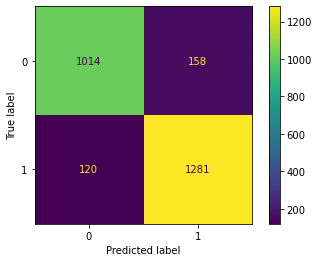

In [19]:
ada_tvec = model('tvec', TfidfVectorizer(), 'ada', AdaBoostClassifier(), tvec_params)
ada_tvec.head().T

df_all.append(ada_tvec)

********************************************************************************
MODEL = AdaBoostClassifier(), VECTORIZER = CountVectorizer()
********************************************************************************
Best fitting parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2)}

Best score: 0.893
Test score: 0.899

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1172
           1       0.93      0.88      0.90      1401

    accuracy                           0.90      2573
   macro avg       0.90      0.90      0.90      2573
weighted avg       0.90      0.90      0.90      2573



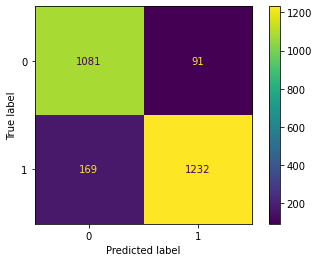

In [20]:
ada_cvec = model('cvec', CountVectorizer(), 'ada', AdaBoostClassifier(), cvec_params)
ada_cvec.head().T

df_all.append(ada_cvec)

********************************************************************************
MODEL = GradientBoostingClassifier(), VECTORIZER = TfidfVectorizer()
********************************************************************************
Best fitting parameters: {'tvec__max_df': 0.9, 'tvec__max_features': None, 'tvec__ngram_range': (1, 2)}

Best score: 0.904
Test score: 0.899

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1172
           1       0.94      0.88      0.90      1401

    accuracy                           0.90      2573
   macro avg       0.90      0.90      0.90      2573
weighted avg       0.90      0.90      0.90      2573



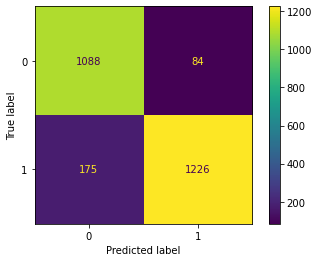

In [21]:
gb_tvec = model('tvec', TfidfVectorizer(), 'gb', GradientBoostingClassifier(), tvec_params)
gb_tvec.head().T

df_all.append(gb_tvec)

********************************************************************************
MODEL = GradientBoostingClassifier(), VECTORIZER = CountVectorizer()
********************************************************************************
Best fitting parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1)}

Best score: 0.904
Test score: 0.9

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1172
           1       0.94      0.87      0.91      1401

    accuracy                           0.90      2573
   macro avg       0.90      0.90      0.90      2573
weighted avg       0.90      0.90      0.90      2573



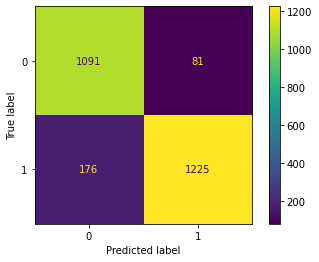

In [22]:
gb_cvec = model('cvec', CountVectorizer(), 'gb', GradientBoostingClassifier(), cvec_params)
gb_cvec.head().T

df_all.append(gb_cvec)

In [23]:
full_df = pd.concat(df_all)

In [24]:
pd.set_option('display.max_colwidth', None)
full_df.sort_values(by=['test_score'], ascending=False).reset_index(drop=True)

,model_vec,best_params,train_score,test_score,sensitivity,specificity,precision,f1_score,tn,fp,fn,tp
0,rf_tvec,"{'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2)}",0.914733,0.914497,0.912206,0.917235,0.929455,0.920749,1075,97,123,1278
1,rf_cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2)}",0.914472,0.912165,0.911492,0.912969,0.926033,0.918705,1070,102,124,1277
2,lr_tvec,"{'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2)}",0.908769,0.902060,0.911492,0.890785,0.908897,0.910192,1044,128,124,1277
3,gb_cvec,"{'cvec__max_df': 0.5, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1)}",0.903586,0.900117,0.874375,0.930887,0.937979,0.905061,1091,81,176,1225
4,gb_tvec,"{'tvec__max_df': 0.9, 'tvec__max_features': None, 'tvec__ngram_range': (1, 2)}",0.903976,0.899339,0.875089,0.928328,0.935878,0.904463,1088,84,175,1226
5,ada_cvec,"{'cvec__max_df': 0.5, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2)}",0.893092,0.898951,0.879372,0.922355,0.931217,0.904552,1081,91,169,1232
6,lr_cvec,"{'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 2)}",0.904495,0.897785,0.887223,0.910410,0.922107,0.904329,1067,105,158,1243
7,ada_tvec,"{'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2)}",0.897626,0.891955,0.914347,0.865188,0.890202,0.902113,1014,158,120,1281
8,nb_cvec,"{'cvec__max_df': 0.5, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2)}",0.892962,0.886514,0.892934,0.878840,0.898062,0.895490,1030,142,150,1251
9,nb_tvec,"{'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2)}",0.878060,0.876409,0.905782,0.841297,0.872165,0.888655,986,186,132,1269


### Feature Importance

In [49]:
v = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5, max_features=5000)
x = v.fit_transform(df['cleantext_stem'])
 
 
rf=RandomForestClassifier()
rf.fit(x,df['subreddit'])
 
#we are not getting the absolute value
feature_importance=pd.DataFrame({'feature':v.get_feature_names(),'feature_importance':rf.feature_importances_})
feature_importance.sort_values('feature_importance',ascending=False).head(10)

,feature,feature_importance
2551,keto,0.137804
1661,fast,0.059439
824,carb,0.029370
80,168,0.022278
4080,start keto,0.014934
4855,window,0.013698
2268,hour,0.013022
3297,omad,0.010884
102,186,0.009849
1266,diet,0.007986


Feature Importance is a score assigned to the features of a Machine Learning model that defines how “important” is a feature to the model’s prediction. By applying our best model -- Random Forest Classifier model with TF-IDF Vectorizer, we got the feature importance of 'keto' as the most important features and followed by 'fast' as the second most important feature.

## Evaluation and Conceptual Understanding

Overall our models performed quite well. As compared to the baseline model, our model are outperformed. Our train and test scores for each model are very similar, indicating that our models are not overfit. The accuracy overall are quite high for basic model evaluation except KNN model with Count Vectorizer where the accurancy score is only 62%.

Generally, TF-IDF transformation works better than Count Vectorizer in model fitting. In Count Vectorizer we only count the number of times a word appears in the document which results in biasing in favour of most frequent words. This ends up in ignoring rare words which could have helped is in processing our data more efficiently. However, in TF-IDF Vectorizer, we consider overall document weightage of a word. It helps us in dealing with most frequent words, using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

From the dataframe above, we can see that the Random Forest model tops the other models in 4 of the 6 metrics we evaluate, except precision and specificity. A score greater than 90% suggests that the model is highly accurate when predicting subreddit. Confusion Matrix from Random Forest shows that there are total 225 false subreddits when running through our test model.

As our problem statement do not focus on capturing either positive predictions or negative predicitions, we should use F1 metric to eveluate our model in this case. Simply stated the F1 score sort of maintains a balance between the precision and recall for your classifier. If our precision is low, the F1 is low and if the recall is low again our F1 score is low ([Reference](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)). By taking F1 metric from our Random Forest model, the interpretation of this value is that on a scale from 0 (worst) to 1 (best), the model’s ability to both capture positive cases and be accurate with the cases it does capture is 0.92, which is very good value.


# Conclusion and Recommendations
In conclusion, Random Forest is the most accurate model tested, sporting about an 91% accuracy. Susequent models that we can use for the subreddits classification are Logistic Regeression and Gradient Boosting Classifier. Furtherore, TF-IDF transformation works better than Count Vectorizer in model fitting.

From our EDA, majority of the subrredits are about 'Keto Diet'. This could indicate that more people are actually interested on keto way. Besides that, we also found that many people are actually on the reddits to seek advices or suggestions to help on their process on interminttent fasting of keto. By refering to scietific article, we realised that both intermittent fasting and keto diet have its advantages and disadvantages. Also, from Dr Anson's article, his advice is to experiment with the dietary plans and see if one works best for you ([Reference](https://drstephenanton.com/keto-vs-intermittent-fasting/)). Therefore, instead of advocating particular way of diet, we could provide professional consultation service toward people who need help throughout their weightloss/health improvement journey via either intermittent fasting or keto diet.

Besides that, sentiment analysis allow us to understand that majority of the posts are positive comments, which possess 75.1%. 

Last but not least, by moving forward with this project, I could do far more exploration with setting different model parameters to check for the improvement. I'd recommend adding more features to the API and to models to strengthen accuracy as well as potential for modeling. Furthermore, I'd explore data drift prevention as surredits post can be updated very soon. It might cause model performance degradation when we use current model to apply on updated posts.